In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Shape du dataset : (62645, 24)
Nombre de features : 24
min_samples recommandé : 48


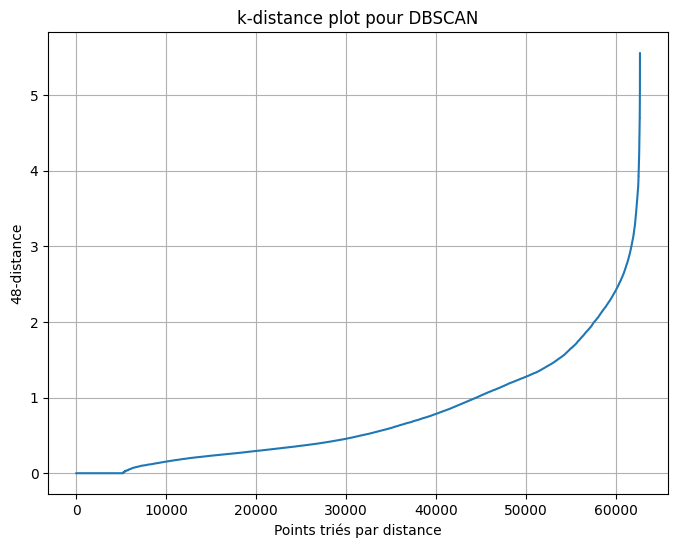

Choisis un eps à partir du k-distance plot (ex: ~22) : 0.5

Nombre de clusters trouvés : 55
Nombre de points considérés comme bruit : 26827
Score de Silhouette          : -0.0397
Indice de Davies–Bouldin     : 1.1894
Indice de Calinski–Harabasz  : 1106.9214


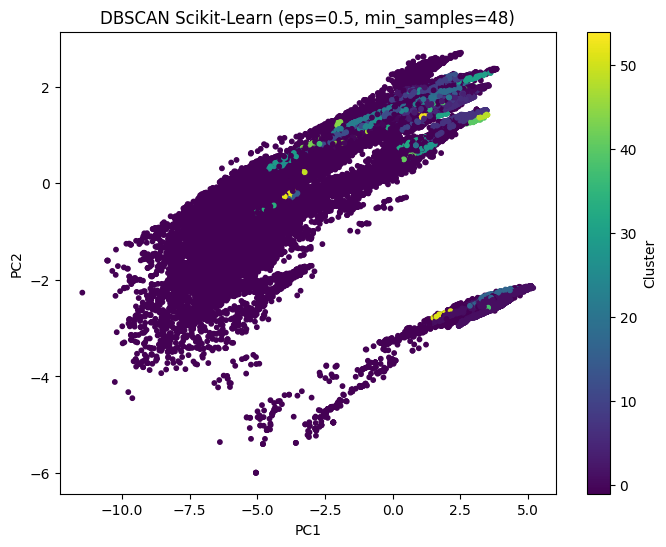

Résultats DBSCAN sauvegardés dans : /content/drive/MyDrive/processed_unsupervised/X_clustered_dbscan_sklearn.csv


In [5]:
# ==========================================
# 1. Imports
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# ==========================================
# 2. Charger les données
# ==========================================
data_dir = "/content/drive/MyDrive/processed_unsupervised"
X = pd.read_csv(f"{data_dir}/X_scaled.csv").values
print("Shape du dataset :", X.shape)

# ==========================================
# 3. Définir min_samples automatiquement
# ==========================================
n_features = X.shape[1]
min_samples = 2 * n_features
print(f"Nombre de features : {n_features}")
print(f"min_samples recommandé : {min_samples}")

# ==========================================
# 4. Calcul des distances au min_samples-ième voisin
# ==========================================
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# La distance au min_samples-ième voisin pour chaque point
k_distances = np.sort(distances[:, -1])

# Affichage du k-distance plot
plt.figure(figsize=(8,6))
plt.plot(k_distances)
plt.xlabel("Points triés par distance")
plt.ylabel(f"{min_samples}-distance")
plt.title("k-distance plot pour DBSCAN")
plt.grid(True)
plt.show()

# ==========================================
# 5. Choisir eps à partir du coude
# ==========================================
eps = float(input("Choisis un eps à partir du k-distance plot (ex: ~22) : "))

# ==========================================
# 6. DBSCAN avec Scikit-Learn
# ==========================================
dbscan_sk = DBSCAN(eps=eps, min_samples=min_samples)
labels_sk = dbscan_sk.fit_predict(X)

n_clusters = len(set(labels_sk)) - (1 if -1 in labels_sk else 0)
n_noise = list(labels_sk).count(-1)

print(f"\nNombre de clusters trouvés : {n_clusters}")
print(f"Nombre de points considérés comme bruit : {n_noise}")

# ==========================================
# 6b. Calcul des métriques de validation
# ==========================================
if n_clusters > 1:
    sil_score = silhouette_score(X, labels_sk)
    db_score = davies_bouldin_score(X, labels_sk)
    ch_score = calinski_harabasz_score(X, labels_sk)

    print(f"Score de Silhouette          : {sil_score:.4f}")
    print(f"Indice de Davies–Bouldin     : {db_score:.4f}")
    print(f"Indice de Calinski–Harabasz  : {ch_score:.4f}")
else:
    print("Impossible de calculer les métriques : moins de 2 clusters.")

# ==========================================
# 7. Visualisation PCA 2D
# ==========================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_sk, cmap="viridis", s=10)
plt.title(f"DBSCAN Scikit-Learn (eps={eps}, min_samples={min_samples})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

# ==========================================
# 8. Sauvegarde des résultats
# ==========================================
df_result = pd.DataFrame(X)
df_result["cluster_dbscan"] = labels_sk
output_path = f"{data_dir}/X_clustered_dbscan_sklearn.csv"
df_result.to_csv(output_path, index=False)
print("Résultats DBSCAN sauvegardés dans :", output_path)


Dimensions des données : (62645, 24)
Dimension de l'espace : 24
Candidats minPts testés : [22, 25, 29, 34, 48, 250]

Analyse automatique :
  - minPts recommandé : 250
  - eps estimé : 2.1834


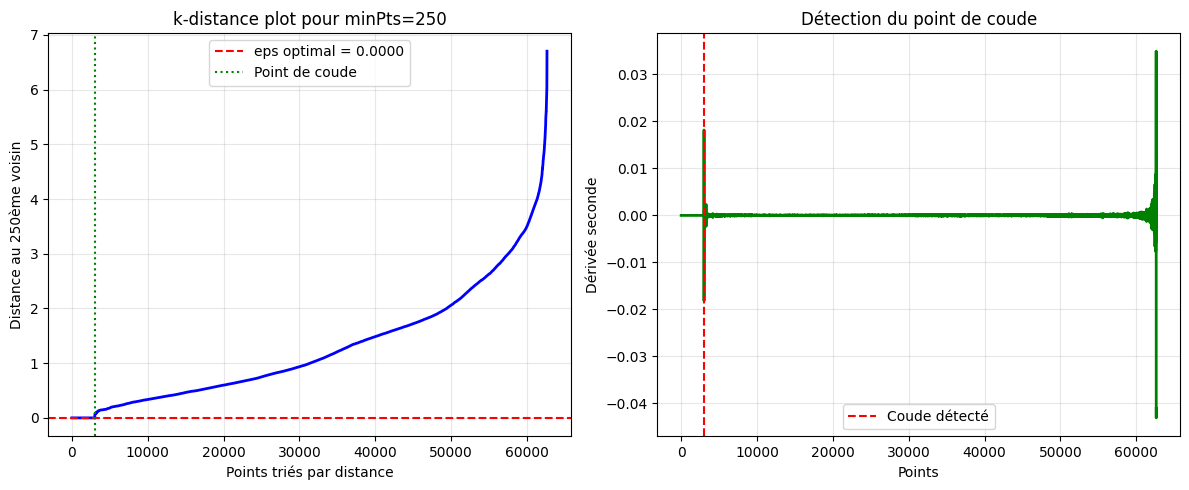


Optimisation fine :
  - minPts : 250
  - eps optimal : 0.0000

EXÉCUTION DBSCAN AVEC PARAMÈTRES OPTIMISÉS


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Charger les données
data_dir = "/content/drive/MyDrive/processed_unsupervised"
X = pd.read_csv(f"{data_dir}/X_scaled.csv").values
dim = X.shape[1]
print(f"Dimensions des données : {X.shape}")
print(f"Dimension de l'espace : {dim}")

# 1. Analyse automatique pour trouver le meilleur minPts
def find_best_minPts(X, dim):
    """Trouve le meilleur minPts basé sur la dimension et l'analyse des voisins"""
    # Règles empiriques
    minPts_candidates = [
        dim + 1,      # Règle minimale
        dim + 5,      # Bon compromis
        dim + 10,     # Plus robuste
        2 * dim,      # Très robuste
        int(np.sqrt(X.shape[0])),  # Basé sur la racine carrée du nombre de points
        int(2 * np.log(X.shape[0]))  # Basé sur le log
    ]

    # Éliminer les doublons et garder les valeurs uniques
    minPts_candidates = sorted(list(set([max(3, int(m)) for m in minPts_candidates])))

    print(f"Candidats minPts testés : {minPts_candidates}")

    # Analyser chaque candidat
    elbow_points = []
    for min_pts in minPts_candidates:
        neighbors = NearestNeighbors(n_neighbors=min_pts)
        neighbors_fit = neighbors.fit(X)
        distances, _ = neighbors_fit.kneighbors(X)
        k_distances = np.sort(distances[:, -1])

        # Trouver le point de coude
        n_points = len(k_distances)
        # Coordonnées extrêmes
        x0, y0 = 0, k_distances[0]
        x1, y1 = n_points-1, k_distances[-1]

        # Calculer la distance perpendiculaire maximale
        distances_perp = []
        for i in range(n_points):
            x = i
            y = k_distances[i]
            # Distance d'un point à une ligne
            num = abs((y1 - y0) * x - (x1 - x0) * y + x1 * y0 - y1 * x0)
            den = np.sqrt((y1 - y0)**2 + (x1 - x0)**2)
            if den > 0:
                distances_perp.append(num / den)

        if len(distances_perp) > 0:
            elbow_idx = np.argmax(distances_perp)
            elbow_value = k_distances[elbow_idx]
            elbow_points.append((min_pts, elbow_value, elbow_idx))

    # Choisir le minPts avec le coude le plus prononcé
    if elbow_points:
        # Trier par position du coude (on préfère les coudes dans la première moitié)
        elbow_points.sort(key=lambda x: (x[2] / len(X), -x[1]))
        best_minPts = elbow_points[0][0]
        best_eps = elbow_points[0][1]
        print(f"\nAnalyse automatique :")
        print(f"  - minPts recommandé : {best_minPts}")
        print(f"  - eps estimé : {best_eps:.4f}")
        return best_minPts, best_eps
    else:
        # Valeurs par défaut si l'analyse échoue
        return dim + 5, 0.5

# Trouver les meilleurs paramètres
best_minPts, estimated_eps = find_best_minPts(X, dim)

# 2. Optimisation fine de eps
def optimize_eps(X, min_pts, eps_range=None):
    """Optimise eps pour un minPts donné"""
    neighbors = NearestNeighbors(n_neighbors=min_pts)
    neighbors_fit = neighbors.fit(X)
    distances, _ = neighbors_fit.kneighbors(X)
    k_distances = np.sort(distances[:, -1])

    # Si aucune plage spécifiée, trouver une plage raisonnable
    if eps_range is None:
        # Prendre les percentiles
        q25 = np.percentile(k_distances, 25)
        q75 = np.percentile(k_distances, 75)
        eps_range = np.linspace(q25 * 0.5, q75 * 1.5, 20)

    # Trouver le point où la courbure est maximale
    n = len(k_distances)
    x = np.arange(n)

    # Calculer la dérivée seconde (approximation)
    derivative = np.gradient(k_distances)
    second_derivative = np.gradient(derivative)

    # Trouver où la dérivée seconde est maximale (changement de courbure)
    elbow_idx = np.argmax(np.abs(second_derivative[:n//2]))  # Chercher dans la première moitié
    best_eps = k_distances[elbow_idx]

    # Visualisation
    plt.figure(figsize=(12, 5))

    # Graphique k-distance
    plt.subplot(1, 2, 1)
    plt.plot(k_distances, 'b-', linewidth=2)
    plt.axhline(y=best_eps, color='r', linestyle='--', label=f'eps optimal = {best_eps:.4f}')
    plt.axvline(x=elbow_idx, color='g', linestyle=':', label=f'Point de coude')
    plt.xlabel('Points triés par distance')
    plt.ylabel(f'Distance au {min_pts}ème voisin')
    plt.title(f'k-distance plot pour minPts={min_pts}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Graphique dérivée seconde
    plt.subplot(1, 2, 2)
    plt.plot(second_derivative, 'g-', linewidth=2)
    plt.axvline(x=elbow_idx, color='r', linestyle='--', label='Coude détecté')
    plt.xlabel('Points')
    plt.ylabel('Dérivée seconde')
    plt.title('Détection du point de coude')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return best_eps

# Optimiser eps
best_eps = optimize_eps(X, best_minPts)
print(f"\nOptimisation fine :")
print(f"  - minPts : {best_minPts}")
print(f"  - eps optimal : {best_eps:.4f}")

# 3. Implémentation DBSCAN avec paramètres optimisés
class DBSCANOptimized:
    def __init__(self, eps=0.5, min_pts=5):
        self.eps = eps
        self.min_pts = min_pts

    def fit(self, X):
        n_samples = X.shape[0]
        labels = np.full(n_samples, -1)  # -1 = noise
        visited = np.zeros(n_samples, dtype=bool)
        cluster_id = 0

        # Précalcul des distances pour optimisation
        from scipy.spatial.distance import cdist
        distance_matrix = cdist(X, X)

        # Fonction pour trouver les voisins
        def region_query(point_idx):
            return np.where(distance_matrix[point_idx] <= self.eps)[0]

        # Fonction pour étendre le cluster
        def expand_cluster(point_idx, neighbors, cluster_id):
            labels[point_idx] = cluster_id
            i = 0
            while i < len(neighbors):
                nbr_idx = neighbors[i]
                if not visited[nbr_idx]:
                    visited[nbr_idx] = True
                    nbr_neighbors = region_query(nbr_idx)
                    if len(nbr_neighbors) >= self.min_pts:
                        neighbors = np.concatenate((neighbors, nbr_neighbors))
                if labels[nbr_idx] == -1:
                    labels[nbr_idx] = cluster_id
                i += 1

        # Parcourir tous les points
        for point_idx in range(n_samples):
            if not visited[point_idx]:
                visited[point_idx] = True
                neighbors = region_query(point_idx)
                if len(neighbors) < self.min_pts:
                    labels[point_idx] = -1  # Noise
                else:
                    expand_cluster(point_idx, neighbors, cluster_id)
                    cluster_id += 1

        self.labels_ = labels
        self.n_clusters_ = cluster_id
        self.n_noise_ = np.sum(labels == -1)
        self.cluster_sizes_ = [np.sum(labels == i) for i in range(cluster_id)]

        return labels

    def get_metrics(self, X):
        """Calcule les métriques de qualité du clustering"""
        if self.n_clusters_ < 2:
            return {
                'silhouette': 0,
                'calinski_harabasz': 0,
                'davies_bouldin': float('inf'),
                'n_clusters': self.n_clusters_,
                'n_noise': self.n_noise_,
                'noise_ratio': self.n_noise_ / len(X)
            }

        # Filtrer les points qui ne sont pas du bruit
        valid_mask = self.labels_ != -1
        if np.sum(valid_mask) > 1:
            X_valid = X[valid_mask]
            labels_valid = self.labels_[valid_mask]

            if len(np.unique(labels_valid)) > 1:
                try:
                    silhouette = silhouette_score(X_valid, labels_valid)
                    calinski = calinski_harabasz_score(X_valid, labels_valid)
                    davies = davies_bouldin_score(X_valid, labels_valid)
                except:
                    silhouette = 0
                    calinski = 0
                    davies = float('inf')
            else:
                silhouette = 0
                calinski = 0
                davies = float('inf')
        else:
            silhouette = 0
            calinski = 0
            davies = float('inf')

        return {
            'silhouette': silhouette,
            'calinski_harabasz': calinski,
            'davies_bouldin': davies,
            'n_clusters': self.n_clusters_,
            'n_noise': self.n_noise_,
            'noise_ratio': self.n_noise_ / len(X),
            'avg_cluster_size': np.mean(self.cluster_sizes_) if self.cluster_sizes_ else 0
        }

# 4. Exécuter DBSCAN avec paramètres optimisés
print("\n" + "="*50)
print("EXÉCUTION DBSCAN AVEC PARAMÈTRES OPTIMISÉS")
print("="*50)

dbscan = DBSCANOptimized(eps=best_eps, min_pts=best_minPts)
labels = dbscan.fit(X)

# Afficher les résultats
print(f"\nRésultats du clustering :")
print(f"  - Nombre de clusters : {dbscan.n_clusters_}")
print(f"  - Points considérés comme bruit : {dbscan.n_noise_} ({dbscan.n_noise_/len(X)*100:.2f}%)")
print(f"  - Taille des clusters : {dbscan.cluster_sizes_}")

# Calculer les métriques
metrics = dbscan.get_metrics(X)
print(f"\nMétriques de qualité :")
print(f"  - Score silhouette : {metrics['silhouette']:.4f} (meilleur si proche de 1)")
print(f"  - Score Calinski-Harabasz : {metrics['calinski_harabasz']:.2f} (plus haut = mieux)")
print(f"  - Score Davies-Bouldin : {metrics['davies_bouldin']:.4f} (plus bas = mieux)")
print(f"  - Taille moyenne des clusters : {metrics['avg_cluster_size']:.1f} points")

# 5. Visualisation
def pca_from_scratch(X, n_components=2):
    """PCA simplifiée pour visualisation"""
    X_centered = X - np.mean(X, axis=0)
    cov_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]
    components = eigenvectors[:, :n_components]
    X_pca = np.dot(X_centered, components)
    return X_pca

X_pca = pca_from_scratch(X, n_components=2)

plt.figure(figsize=(14, 6))

# Visualisation PCA
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab20', s=10, alpha=0.6)
plt.title(f'DBSCAN - {dbscan.n_clusters_} clusters (eps={best_eps:.3f}, minPts={best_minPts})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='Cluster ID')
# Marquer les points de bruit en noir
noise_mask = labels == -1
if np.any(noise_mask):
    plt.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1],
                c='black', s=5, alpha=0.3, label='Bruit')
    plt.legend()

# Histogramme des tailles de clusters
plt.subplot(1, 2, 2)
if dbscan.n_clusters_ > 0:
    plt.bar(range(dbscan.n_clusters_), dbscan.cluster_sizes_)
    plt.xlabel('Cluster ID')
    plt.ylabel('Nombre de points')
    plt.title(f'Distribution des tailles de clusters\n(Bruit : {dbscan.n_noise_} points)')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Aucun cluster trouvé\nTous les points sont du bruit',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Aucun cluster détecté')

plt.tight_layout()
plt.show()

# 6. Sauvegarde des résultats
print("\n" + "="*50)
print("SAUVEGARDE DES RÉSULTATS")
print("="*50)

# Créer un DataFrame avec les résultats
df_result = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(dim)])
df_result['cluster_dbscan'] = labels
df_result['is_noise'] = (labels == -1)

# Sauvegarder les résultats
output_path = f"{data_dir}/X_clustered_dbscan_optimized.csv"
df_result.to_csv(output_path, index=False)
print(f"Résultats sauvegardés dans : {output_path}")

# Sauvegarder les paramètres et métriques
params_metrics = {
    'eps': best_eps,
    'min_pts': best_minPts,
    'n_clusters': dbscan.n_clusters_,
    'n_noise': dbscan.n_noise_,
    'noise_ratio': dbscan.n_noise_ / len(X),
    'silhouette_score': metrics['silhouette'],
    'calinski_harabasz_score': metrics['calinski_harabasz'],
    'davies_bouldin_score': metrics['davies_bouldin'],
    'avg_cluster_size': metrics['avg_cluster_size'],
    'cluster_sizes': dbscan.cluster_sizes_
}

params_df = pd.DataFrame([params_metrics])
params_path = f"{data_dir}/dbscan_parameters_metrics.csv"
params_df.to_csv(params_path, index=False)
print(f"Paramètres et métriques sauvegardés dans : {params_path}")

# 7. Résumé final
print("\n" + "="*50)
print("RÉSUMÉ FINAL")
print("="*50)
print(f"PARAMÈTRES OPTIMAUX RETENUS :")
print(f"  • eps = {best_eps:.4f}")
print(f"  • minPts = {best_minPts}")
print(f"\nRÉSULTATS OBTENUS :")
print(f"  • Nombre de clusters : {dbscan.n_clusters_}")
print(f"  • Points de bruit : {dbscan.n_noise_} ({dbscan.n_noise_/len(X)*100:.2f}%)")
if dbscan.n_clusters_ > 0:
    print(f"  • Taille des clusters : {', '.join(map(str, dbscan.cluster_sizes_))}")
print(f"\nQUALITÉ DU CLUSTERING :")
print(f"  • Score silhouette : {metrics['silhouette']:.4f}")
print(f"    → {get_silhouette_interpretation(metrics['silhouette'])}")
print(f"  • Score Davies-Bouldin : {metrics['davies_bouldin']:.4f}")
print(f"    → {get_davies_interpretation(metrics['davies_bouldin'])}")

# Fonctions d'interprétation
def get_silhouette_interpretation(score):
    if score > 0.7:
        return "Structure forte détectée"
    elif score > 0.5:
        return "Structure raisonnable"
    elif score > 0.25:
        return "Structure faible"
    else:
        return "Structure peu définie ou trop de bruit"

def get_davies_interpretation(score):
    if score < 0.5:
        return "Clusters bien séparés"
    elif score < 1.0:
        return "Séparation acceptable"
    elif score < 2.0:
        return "Séparation faible"
    else:
        return "Clusters mal séparés"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Nombre de clusters trouvés : 699
Labels DBSCAN (extrait) : [ 0  1  2  3  1  0  2  3  1  0  1  1 -1 -1  4  1  3  5  6  7]


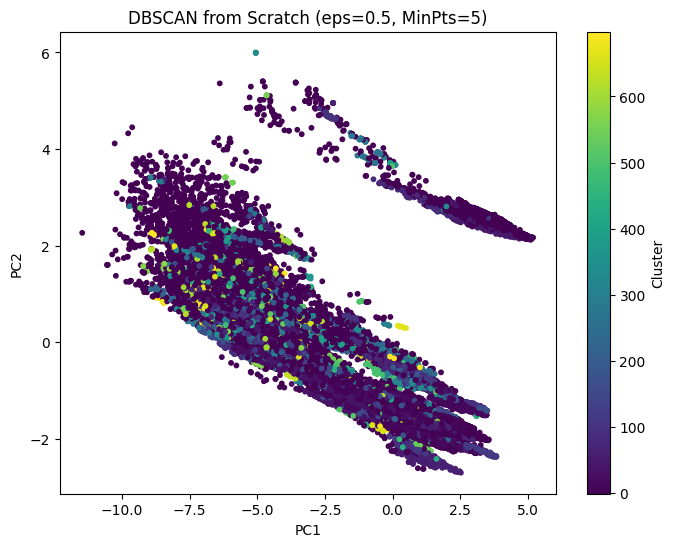

Résultats DBSCAN sauvegardés dans : /content/drive/MyDrive/processed_unsupervised/X_clustered_dbscan.csv


In [3]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données
data_dir = "/content/drive/MyDrive/processed_unsupervised"
X = pd.read_csv(f"{data_dir}/X_scaled.csv").values

# DBSCAN Parameters
eps = 0.5       # distance maximale pour considérer un voisin
min_pts = 5     # nombre minimum de voisins pour un point core

# DBSCAN from scratch
class DBSCANScratch:
    def __init__(self, eps=0.5, min_pts=5):
        self.eps = eps
        self.min_pts = min_pts

    def fit(self, X):
        n_samples = X.shape[0]
        labels = np.full(n_samples, -1)  # -1 = noise
        visited = np.zeros(n_samples, dtype=bool)
        cluster_id = 0

        # Fonction pour trouver les voisins
        def region_query(point_idx):
            distances = np.linalg.norm(X - X[point_idx], axis=1)
            neighbors = np.where(distances <= self.eps)[0]
            return neighbors

        # Fonction pour étendre le cluster
        def expand_cluster(point_idx, neighbors, cluster_id):
            labels[point_idx] = cluster_id
            i = 0
            while i < len(neighbors):
                nbr_idx = neighbors[i]
                if not visited[nbr_idx]:
                    visited[nbr_idx] = True
                    nbr_neighbors = region_query(nbr_idx)
                    if len(nbr_neighbors) >= self.min_pts:
                        neighbors = np.concatenate((neighbors, nbr_neighbors))
                if labels[nbr_idx] == -1:
                    labels[nbr_idx] = cluster_id
                i += 1

        # Parcourir tous les points
        for point_idx in range(n_samples):
            if not visited[point_idx]:
                visited[point_idx] = True
                neighbors = region_query(point_idx)
                if len(neighbors) < self.min_pts:
                    labels[point_idx] = -1  # Noise
                else:
                    expand_cluster(point_idx, neighbors, cluster_id)
                    cluster_id += 1

        self.labels_ = labels
        self.n_clusters_ = cluster_id
        return labels

# PCA from scratch pour la visualisation
def pca_from_scratch(X, n_components=2):
    """
    Implémentation simplifiée de PCA
    """
    # Centrer les données
    X_centered = X - np.mean(X, axis=0)

    # Calculer la matrice de covariance
    cov_matrix = np.cov(X_centered, rowvar=False)

    # Calculer les valeurs et vecteurs propres
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Trier par valeurs propres décroissantes
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Sélectionner les n_components premiers
    components = eigenvectors[:, :n_components]

    # Projection
    X_pca = np.dot(X_centered, components)

    return X_pca

# Exécuter DBSCAN
dbscan = DBSCANScratch(eps=0.5, min_pts=5)
labels_dbscan = dbscan.fit(X)

print("Nombre de clusters trouvés :", dbscan.n_clusters_)
print("Labels DBSCAN (extrait) :", labels_dbscan[:20])

# Calculer PCA pour la visualisation
X_pca = pca_from_scratch(X, n_components=2)

# Visualiser les résultats
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_dbscan, cmap="viridis", s=10)
plt.title(f"DBSCAN from Scratch (eps={eps}, MinPts={min_pts})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

# Sauvegarder les résultats
df_result = pd.DataFrame(X)
df_result["cluster_dbscan"] = labels_dbscan
output_path = f"{data_dir}/X_clustered_dbscan.csv"
df_result.to_csv(output_path, index=False)
print("Résultats DBSCAN sauvegardés dans :", output_path)

k-distance plot pour DBSCAN

Shape du dataset : (62645, 24)
minPts : 5


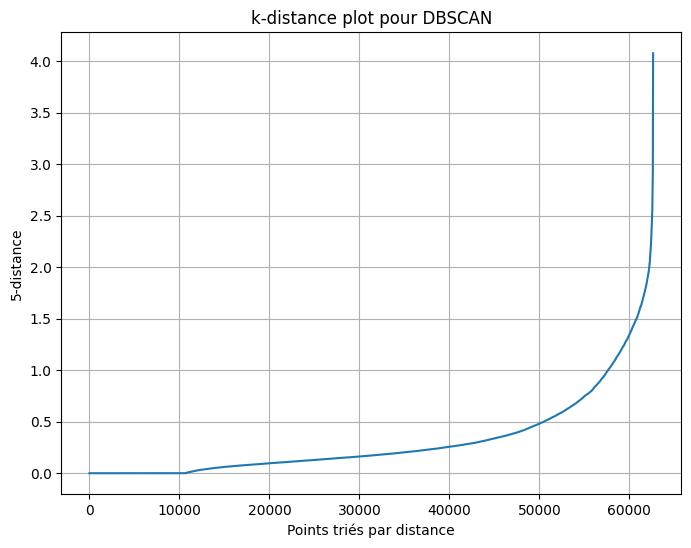

In [ ]:
# ==========================================
# 1. Imports
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# ==========================================
# 2. Charger les données
# ==========================================
data_dir = "/content/drive/MyDrive/processed_unsupervised"
X = pd.read_csv(f"{data_dir}/X_scaled.csv").values

print("Shape du dataset :", X.shape)

# ==========================================
# 3. Paramètre minPts pour DBSCAN
# ==========================================
min_pts = 5  # tu peux tester 2*dim aussi
print("minPts :", min_pts)

# ==========================================
# 4. Calcul des distances au minPts-ième voisin
# ==========================================
neighbors = NearestNeighbors(n_neighbors=min_pts)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# La distance au minPts-ième voisin pour chaque point
k_distances = np.sort(distances[:, -1])

# ==========================================
# 5. Affichage du k-distance plot
# ==========================================
plt.figure(figsize=(8,6))
plt.plot(k_distances)
plt.xlabel("Points triés par distance")
plt.ylabel(f"{min_pts}-distance")
plt.title("k-distance plot pour DBSCAN")
plt.grid(True)
plt.show()


DBSCAN avec k-distance plot + comparaison Scikit-Learn

Shape du dataset : (62645, 24)
minPts : 5


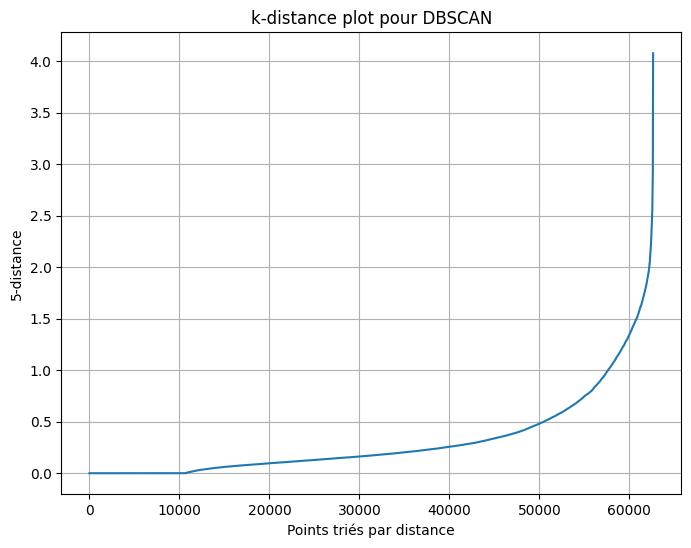

Choisis un eps à partir du k-distance plot : 0.5

Nombre de clusters trouvés : 699
Nombre de points considérés comme bruit : 10380


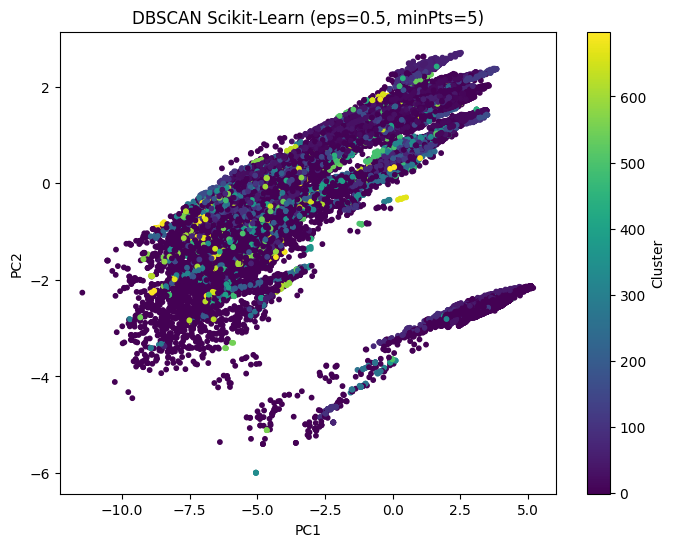

Résultats DBSCAN sauvegardés dans : /content/drive/MyDrive/processed_unsupervised/X_clustered_dbscan_sklearn.csv


In [ ]:
# ==========================================
# 1. Imports
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# ==========================================
# 2. Charger les données
# ==========================================
data_dir = "/content/drive/MyDrive/processed_unsupervised"
X = pd.read_csv(f"{data_dir}/X_scaled.csv").values
print("Shape du dataset :", X.shape)

# ==========================================
# 3. Paramètre minPts pour DBSCAN
# ==========================================
min_pts = 5  # tu peux tester 2*dim aussi
print("minPts :", min_pts)

# ==========================================
# 4. Calcul des distances au minPts-ième voisin
# ==========================================
neighbors = NearestNeighbors(n_neighbors=min_pts)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# La distance au minPts-ième voisin pour chaque point
k_distances = np.sort(distances[:, -1])

# Affichage du k-distance plot
plt.figure(figsize=(8,6))
plt.plot(k_distances)
plt.xlabel("Points triés par distance")
plt.ylabel(f"{min_pts}-distance")
plt.title("k-distance plot pour DBSCAN")
plt.grid(True)
plt.show()

# ==========================================
# 5. Choisir eps à partir du coude
# ==========================================
eps = float(input("Choisis un eps à partir du k-distance plot : "))

# ==========================================
# 6. DBSCAN avec Scikit-Learn
# ==========================================
dbscan_sk = DBSCAN(eps=eps, min_samples=min_pts)
labels_sk = dbscan_sk.fit_predict(X)

n_clusters = len(set(labels_sk)) - (1 if -1 in labels_sk else 0)
n_noise = list(labels_sk).count(-1)

print(f"\nNombre de clusters trouvés : {n_clusters}")
print(f"Nombre de points considérés comme bruit : {n_noise}")

# ==========================================
# 7. Visualisation PCA 2D
# ==========================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_sk, cmap="viridis", s=10)
plt.title(f"DBSCAN Scikit-Learn (eps={eps}, minPts={min_pts})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

# ==========================================
# 8. Sauvegarde des résultats
# ==========================================
df_result = pd.DataFrame(X)
df_result["cluster_dbscan"] = labels_sk
output_path = f"{data_dir}/X_clustered_dbscan_sklearn.csv"
df_result.to_csv(output_path, index=False)
print("Résultats DBSCAN sauvegardés dans :", output_path)


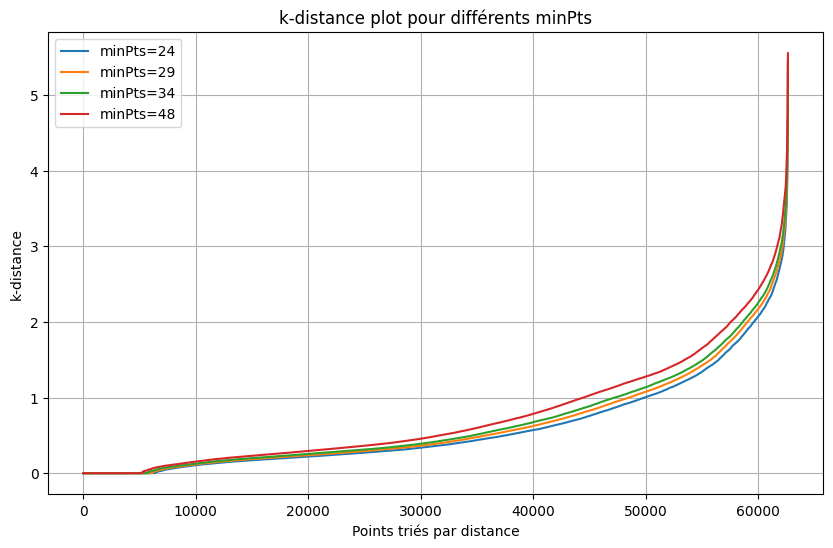

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Charger les données
data_dir = "/content/drive/MyDrive/processed_unsupervised"
X = pd.read_csv(f"{data_dir}/X_scaled.csv").values
dim = X.shape[1]

# Choix automatique de minPts
minPts_candidates = [dim, dim+5, dim+10, dim*2]

plt.figure(figsize=(10,6))
for min_pts in minPts_candidates:
    neighbors = NearestNeighbors(n_neighbors=min_pts)
    neighbors_fit = neighbors.fit(X)
    distances, _ = neighbors_fit.kneighbors(X)
    k_distances = np.sort(distances[:, -1])
    plt.plot(k_distances, label=f"minPts={min_pts}")

plt.xlabel("Points triés par distance")
plt.ylabel("k-distance")
plt.title("k-distance plot pour différents minPts")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ==========================================
# 1. Imports
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# ==========================================
# 2. Charger les données
# ==========================================
data_dir = "/content/drive/MyDrive/processed_unsupervised"
X = pd.read_csv(f"{data_dir}/X_scaled.csv").values
print("Shape du dataset :", X.shape)

# ==========================================
# 3. Paramètre minPts pour DBSCAN
# ==========================================
min_pts = 5  # tu peux tester 2*dim aussi
print("minPts :", min_pts)

# ==========================================
# 4. Calcul des distances au minPts-ième voisin
# ==========================================
neighbors = NearestNeighbors(n_neighbors=min_pts)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# La distance au minPts-ième voisin pour chaque point
k_distances = np.sort(distances[:, -1])

# Affichage du k-distance plot
plt.figure(figsize=(8,6))
plt.plot(k_distances)
plt.xlabel("Points triés par distance")
plt.ylabel(f"{min_pts}-distance")
plt.title("k-distance plot pour DBSCAN")
plt.grid(True)
plt.show()

# ==========================================
# 5. Choisir eps à partir du coude
# ==========================================
eps = float(input("Choisis un eps à partir du k-distance plot : "))

# ==========================================
# 6. DBSCAN avec Scikit-Learn
# ==========================================
dbscan_sk = DBSCAN(eps=eps, min_samples=min_pts)
labels_sk = dbscan_sk.fit_predict(X)

n_clusters = len(set(labels_sk)) - (1 if -1 in labels_sk else 0)
n_noise = list(labels_sk).count(-1)

print(f"\nNombre de clusters trouvés : {n_clusters}")
print(f"Nombre de points considérés comme bruit : {n_noise}")

# ==========================================
# 6b. Calcul des métriques de validation
# ==========================================
# Pour les métriques, il faut au moins 2 clusters
if n_clusters > 1:
    sil_score = silhouette_score(X, labels_sk)
    db_score = davies_bouldin_score(X, labels_sk)
    ch_score = calinski_harabasz_score(X, labels_sk)

    print(f"Score de Silhouette          : {sil_score:.4f}")
    print(f"Indice de Davies–Bouldin     : {db_score:.4f}")
    print(f"Indice de Calinski–Harabasz  : {ch_score:.4f}")
else:
    print("Impossible de calculer les métriques : moins de 2 clusters.")

# ==========================================
# 7. Visualisation PCA 2D
# ==========================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_sk, cmap="viridis", s=10)
plt.title(f"DBSCAN Scikit-Learn (eps={eps}, minPts={min_pts})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

# ==========================================
# 8. Sauvegarde des résultats
# ==========================================
df_result = pd.DataFrame(X)
df_result["cluster_dbscan"] = labels_sk
output_path = f"{data_dir}/X_clustered_dbscan_sklearn.csv"
df_result.to_csv(output_path, index=False)
print("Résultats DBSCAN sauvegardés dans :", output_path)
